<a href="https://colab.research.google.com/github/fabriciosantana/mcdia/blob/main/01-icd/assignments/02-final/analise-discursos-senadores-56-legislatura.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise de discursos da 56ª Legislatura (2019-2023) do plenário do Senado Federal

Fabricio Fernandes Santana  
Disciplina: Fundamentos da Ciência de Dados no Setor Público - 2025.2


## 1. Introdução
Este projeto realiza uma análise completa dos discursos proferidos no plenário do Senado Federal durante a 56ª Legislatura (2019-2023). Para isso, foi realizada a preparação dos dados, análises descritivas e desenvolvimento de modelos supervisionados para predizer o partido político do orador a partir do texto do discurso.

Questão orientadora: **será possível identificar o partido do senador apenas observando o conteúdo textual do pronunciamento?** Essa pergunta interessa porque os partidos articulam agendas distintas e seus discursos sinalizam alinhamento com temas específicos. Responder a questão exige compreender o comportamento temporal dos pronunciamentos, avaliar a qualidade dos dados e construir uma pipeline de processamento textual e modelagem preditiva.

Este trabalho é motivado por uma necessidade de accountability: acompanhar como partidos estruturam seus discursos em temas públicos (saúde, economia, direitos sociais) e verificar a coerência programática ao longo do tempo. A classificação automática dos pronunciamentos por partido permite monitorar alinhamentos e detectar eventuais desvios ou mudanças de agenda, fornecendo insumos para órgãos de controle, jornalistas e sociedade civil em processos de transparência e tomada de decisão.

### 1.1 Problema público, narrativa e decisão
- **Início (contexto):** o Senado é canal central de formulação de políticas; discursos indicam prioridades de cada legenda.
- **Conflito:** sem monitoramento contínuo, torna-se difícil cobrar coerência entre discurso e agenda, especialmente com alta rotatividade de temas (pandemia, recuperação econômica, eleições).
- **Resolução proposta:** usar dados abertos dos discursos para monitorar comportamento textual, estimar o partido provável e, assim, oferecer um painel de accountability que sinalize convergências/divergências e auxilie decisões de fiscalização ou comunicação institucional.

## 2. Análise Descritiva Preliminar

Para a análise descritiva, o dataset de discursos da 56ª Legislatura é carregado diretamente do repositório no [Hugging Face](https://huggingface.co/datasets/fabriciosantana/discursos-senado-legislatura-56).  Salienta-se que o conjunto de dados utilizado neste trabalho foi consolidado por este autor a partir do portal Dados Abertos do Senado utilizando scripts que disponíveis no [repositório do GitHub](https://github.com/fabriciosantana/mcdia/blob/main/01-icd/assignments/01-preparar-base-discursos.ipynb), tornando possível a criação de um novo dataset.


A construção da base bruta (raspagem, limpeza e deduplicação) está documentada em `01-preparar-base-discursos.ipynb`, agora copiado para esta pasta final. Aqui partimos do dataset já consolidado, mas mantemos o link para reprodutibilidade e auditoria do pipeline de dados.

### 2.0 Referência de preparação de dados
- Fonte primária: portal Dados Abertos do Senado (discursos da 56ª Legislatura).
- Pipeline (ver `01-preparar-base-discursos.ipynb`): extração via API, limpeza de HTML/acentos, recorte temporal, remoção de duplicatas, consolidação em CSV/parquet e publicação na Hugging Face.
- Garantias de qualidade: checagem de missing nas colunas-chave (`Data`, `TextoDiscursoIntegral`, `NomeAutor`, `Partido`), filtros de tamanho mínimo e normalização de encoding.
- Transparência: o notebook de preparação permite reexecutar a coleta e inspecionar decisões de limpeza, endereçando a exigência de prestação de contas sobre os dados usados.

### 2.1 Importar Bibliotecas

Nesta seção são importadas as bibliotecas que serão utilizadas ao longo do notebook

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from datasets import load_dataset
from datasets import load_dataset_builder
import re

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)


### 2.2 Carregar Dados

Considerando que o dataset foi previamente disponibilizado no [repositório do Hugging Face](https://huggingface.co/datasets/fabriciosantana/discursos-senado-legislatura-56), os dados são recuperados e informações chave sobre colunas, tipos e completude são previamente avaliados antes de evoluir para outras análises.

In [2]:
DATASET_HF_REPO = "fabriciosantana/discursos-senado-legislatura-56"
DATA_FILE_HF = {"train": "data/full/discursos_2019-02-01_2023-01-31.parquet"}

ds_builder = load_dataset_builder(DATASET_HF_REPO)
display(ds_builder.info)

dataset = load_dataset(DATASET_HF_REPO, data_files=DATA_FILE_HF)
df_raw = dataset["train"].to_pandas()
df_raw['Data'] = pd.to_datetime(df_raw['Data'], errors='coerce')

print(f'Linhas: {len(df_raw):,} | Colunas: {df_raw.shape[1]}')
df_raw.head()

DatasetInfo(description='', citation='', homepage='', license='', features={'id': Value('string'), 'CodigoPronunciamento': Value('string'), 'Casa': Value('string'), 'Data': Value('string'), 'Resumo': Value('string'), 'Indexacao': Value('string'), 'TextoIntegral': Value('string'), 'TextoIntegralTxt': Value('string'), 'UrlTextoBinario': Value('string'), 'TipoAutor': Value('string'), 'FuncaoAutor': Value('string'), 'NomeAutor': Value('string'), 'CodigoParlamentar': Value('string'), 'Partido': Value('string'), 'UF': Value('string'), 'TipoUsoPalavra.Codigo': Value('string'), 'TipoUsoPalavra.Sigla': Value('string'), 'TipoUsoPalavra.Descricao': Value('string'), 'TipoUsoPalavra.IndicadorAtivo': Value('string'), 'Publicacoes.Publicacao': List({'DataPublicacao': Value('string'), 'FontePublicacao': Value('string'), 'PaginaFinal': Value('string'), 'PaginaInicial': Value('string'), 'SiglaFonte': Value('string'), 'TipoPublicacao': Value('string'), 'UrlDiario': Value('string')}), 'Apartes.Aparteante'

Linhas: 15,729 | Colunas: 30


,id,CodigoPronunciamento,Casa,Data,Resumo,Indexacao,TextoIntegral,TextoIntegralTxt,UrlTextoBinario,TipoAutor,...,Apartes.Aparteante,__janela_inicio,__janela_fim,CargoAutor,OrgaoAutor,PaisAutor,TextoDiscursoIntegral,ok,status,msg
0,451286,451286,Senado Federal,2019-02-27,Comentários a respeito da concentração bancári...,"COMENTARIO, CONCENTRAÇÃO, REDE BANCARIA, COBRA...",https://www25.senado.leg.br/web/atividade/pron...,https://legis.senado.leg.br/dadosabertos/discu...,https://legis.senado.leg.br/dadosabertos/discu...,Senador(a),...,None,2019-02-01,2019-03-03,None,None,None,SENADO FEDERAL SF -\nSECRETARIA-GERAL DA MESA\...,True,200,
1,451285,451285,Senado Federal,2019-02-27,Registro do impacto da reforma da previdência ...,"REGISTRO, REFORMA, PREVIDENCIA SOCIAL, ALTERAÇ...",https://www25.senado.leg.br/web/atividade/pron...,https://legis.senado.leg.br/dadosabertos/discu...,https://legis.senado.leg.br/dadosabertos/discu...,Senador(a),...,None,2019-02-01,2019-03-03,None,None,None,SENADO FEDERAL SF -\nSECRETARIA-GERAL DA MESA\...,True,200,
2,451205,451205,Senado Federal,2019-02-27,Comentários a respeito da catástrofe ocorrida ...,"COMENTARIO, DESASTRE, ROMPIMENTO, BARRAGEM, BR...",https://www25.senado.leg.br/web/atividade/pron...,https://legis.senado.leg.br/dadosabertos/discu...,https://legis.senado.leg.br/dadosabertos/discu...,Senador(a),...,None,2019-02-01,2019-03-03,None,None,None,O SR. WELLINGTON FAGUNDES (Bloco Parlamentar V...,True,200,
3,451203,451203,Senado Federal,2019-02-27,Expectativa com o início dos trabalhos no âmbi...,"EXPECTATIVA, INICIO, TRABALHO, COMISSÕES, SENA...",https://www25.senado.leg.br/web/atividade/pron...,https://legis.senado.leg.br/dadosabertos/discu...,https://legis.senado.leg.br/dadosabertos/discu...,Senador(a),...,None,2019-02-01,2019-03-03,None,None,None,O SR. CONFÚCIO MOURA (Bloco Parlamentar Unidos...,True,200,
4,451202,451202,Senado Federal,2019-02-27,Relato da origem e das motivações do Projeto d...,"COMENTARIO, ORIGEM, MOTIVO, PROJETO DE LEI, OB...",https://www25.senado.leg.br/web/atividade/pron...,https://legis.senado.leg.br/dadosabertos/discu...,https://legis.senado.leg.br/dadosabertos/discu...,Senador(a),...,None,2019-02-01,2019-03-03,None,None,None,O SR. RODRIGO PACHECO (Bloco Parlamentar Vangu...,True,200,


### 2.2.1 Analisar a estrutura do dataframe

A exibição de `df_raw.shape` e `df_raw.info()` revela a composição do conjunto bruto. Conhecer a quantidade de linhas e colunas, bem como os tipos de cada campo, orienta etapas posteriores de limpeza e ajuda a identificar colunas com preenchimento irregular logo no início da exploração.


In [3]:
print(f'Linhas: {df_raw.shape[0]:,} | Colunas: {df_raw.shape[1]}')
df_raw.info()


Linhas: 15,729 | Colunas: 30
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15729 entries, 0 to 15728
Data columns (total 30 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   id                             15729 non-null  object        
 1   CodigoPronunciamento           15729 non-null  object        
 2   Casa                           15729 non-null  object        
 3   Data                           15729 non-null  datetime64[ns]
 4   Resumo                         15672 non-null  object        
 5   Indexacao                      15694 non-null  object        
 6   TextoIntegral                  15729 non-null  object        
 7   TextoIntegralTxt               15729 non-null  object        
 8   UrlTextoBinario                15729 non-null  object        
 9   TipoAutor                      15729 non-null  object        
 10  FuncaoAutor                    15729 non-null  object

### 2.3 Obter uma visão geral dos tipos de dados e da quantidade de valores ausentes por coluna

Nesta seção monta-se um DataFrame auxiliar com `dtype`, contagem de `missing` e percentual faltante, ordenando pelas colunas mais críticas. Dessa forma obtém-se uma tabela que orienta quais variáveis demandam tratamentos específicos antes da modelagem.

In [4]:
overview = (
    pd.DataFrame({
        'dtype': df_raw.dtypes.astype(str),
        'missing': df_raw.isna().sum()
    })
    .assign(missing_pct=lambda df: (df['missing'] / len(df_raw) * 100).round(2))
    .sort_values('missing', ascending=False)
)
overview.head(10)


,dtype,missing,missing_pct
PaisAutor,object,15632,99.38
OrgaoAutor,object,14918,94.84
Apartes.Aparteante,object,14861,94.48
CargoAutor,object,14825,94.25
Partido,object,2074,13.19
CodigoParlamentar,object,2074,13.19
UF,object,2074,13.19
Publicacoes.Publicacao,object,734,4.67
Resumo,object,57,0.36
Indexacao,object,35,0.22


### 2.4 Sintetizar indicadores-chave sobre o volume e a diversidade do corpus de discursos

Nesta seção são calculadas as contagens de discursos, autores, partidos, estados e datas distintas usando uma `Series`. Com isso, é obtida uma tabela de métricas que contextualiza a dimensão do problema e apoia interpretações posteriores.

In [5]:
metrics = pd.Series({
    'Discursos': len(df_raw),
    'Autores unicos': df_raw['NomeAutor'].nunique(),
    'Partidos unicos': df_raw['Partido'].nunique(),
    'Estados representados': df_raw['UF'].nunique(),
    'Datas distintas': df_raw['Data'].nunique()
})
metrics.to_frame('valor')


,valor
Discursos,15729
Autores unicos,1794
Partidos unicos,32
Estados representados,27
Datas distintas,604


### 2.5. Detalhar as colunas com maior incidência de valores faltantes

Para detalhar as colunas com maior incidência de valores faltantes, são contabilizados `NaN` por coluna, computado o percentual relativo e ordenado do maior para o menor. Dessa forma, é obtido um DataFrame que prioriza variáveis que necessitam limpeza ou imputação.

In [6]:
missing = (
    df_raw.isna()
        .sum()
        .to_frame('faltantes')
        .assign(percentual=lambda df: (df['faltantes'] / len(df_raw) * 100).round(2))
        .sort_values('faltantes', ascending=False)
)
missing.head(12)


,faltantes,percentual
PaisAutor,15632,99.38
OrgaoAutor,14918,94.84
Apartes.Aparteante,14861,94.48
CargoAutor,14825,94.25
Partido,2074,13.19
CodigoParlamentar,2074,13.19
UF,2074,13.19
Publicacoes.Publicacao,734,4.67
Resumo,57,0.36
Indexacao,35,0.22


### 2.6 Preparar atributos derivados que serão usados na análise exploratória e no modelo supervisionado

Além de copiar o conjunto bruto para `df`, criamos colunas auxiliares de tempo (`ano`, `mes`, `dia_semana`) e medimos o comprimento dos textos integrais. Essa preparação retoma a etapa do projeto parcial, garantindo que o corpus esteja pronto para agregações temporais, inspeções de qualidade e filtros de tamanho antes da modelagem supervisionada.


In [7]:
df = df_raw.copy()

df['ano'] = df['Data'].dt.year
# Representacao mensal padronizada
mes_periodo = df['Data'].dt.to_period('M')
df['mes'] = mes_periodo.dt.to_timestamp()

dias_semana_pt = {
    0: 'Segunda',
    1: 'Terca',
    2: 'Quarta',
    3: 'Quinta',
    4: 'Sexta',
    5: 'Sabado',
    6: 'Domingo'
}
df['dia_semana'] = df['Data'].dt.dayofweek.map(dias_semana_pt)

# Limpar e medir o texto integral
texto_coluna = 'TextoDiscursoIntegral'
df[texto_coluna] = df[texto_coluna].fillna('').str.strip()
df['texto_len_palavras'] = df[texto_coluna].str.split().str.len()
df['texto_len_caracteres'] = df[texto_coluna].str.len()

df.head(3)


,id,CodigoPronunciamento,Casa,Data,Resumo,Indexacao,TextoIntegral,TextoIntegralTxt,UrlTextoBinario,TipoAutor,...,PaisAutor,TextoDiscursoIntegral,ok,status,msg,ano,mes,dia_semana,texto_len_palavras,texto_len_caracteres
0,451286,451286,Senado Federal,2019-02-27,Comentários a respeito da concentração bancári...,"COMENTARIO, CONCENTRAÇÃO, REDE BANCARIA, COBRA...",https://www25.senado.leg.br/web/atividade/pron...,https://legis.senado.leg.br/dadosabertos/discu...,https://legis.senado.leg.br/dadosabertos/discu...,Senador(a),...,None,SENADO FEDERAL SF -\nSECRETARIA-GERAL DA MESA\...,True,200,,2019,2019-02-01,Quarta,873,5650
1,451285,451285,Senado Federal,2019-02-27,Registro do impacto da reforma da previdência ...,"REGISTRO, REFORMA, PREVIDENCIA SOCIAL, ALTERAÇ...",https://www25.senado.leg.br/web/atividade/pron...,https://legis.senado.leg.br/dadosabertos/discu...,https://legis.senado.leg.br/dadosabertos/discu...,Senador(a),...,None,SENADO FEDERAL SF -\nSECRETARIA-GERAL DA MESA\...,True,200,,2019,2019-02-01,Quarta,1588,10113
2,451205,451205,Senado Federal,2019-02-27,Comentários a respeito da catástrofe ocorrida ...,"COMENTARIO, DESASTRE, ROMPIMENTO, BARRAGEM, BR...",https://www25.senado.leg.br/web/atividade/pron...,https://legis.senado.leg.br/dadosabertos/discu...,https://legis.senado.leg.br/dadosabertos/discu...,Senador(a),...,None,O SR. WELLINGTON FAGUNDES (Bloco Parlamentar V...,True,200,,2019,2019-02-01,Quarta,4682,28440


### 2.7. Analisar a evolução temporal do número de discursos

A série mensal de pronunciamentos ajuda a visualizar sazonalidades do trabalho legislativo. Ao agregar o número de discursos por mês, identificamos picos em períodos de votação expressiva e quedas associadas a recessos parlamentares, tal como discutido no relatório parcial.


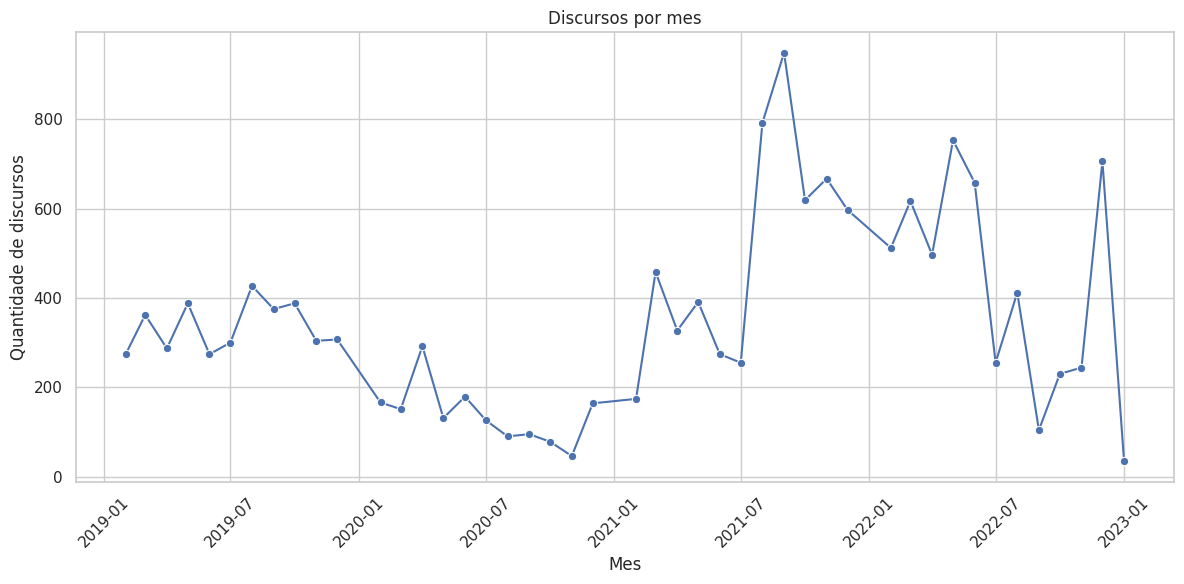

In [8]:
discursos_por_mes = (
    df.groupby('mes')
      .size()
      .reset_index(name='discursos')
      .sort_values('mes')
)

fig, ax = plt.subplots()
sns.lineplot(data=discursos_por_mes, x='mes', y='discursos', ax=ax, marker='o')
ax.set(title='Discursos por mes', xlabel='Mes', ylabel='Quantidade de discursos')
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()


### 2.8. Identificar os autores mais atuantes no plenário

O ranking de autores evidencia quais senadores dominam a tribuna. Parlamentares como Izalci Lucas e Randolfe Rodrigues costumam figurar entre os maiores oradores, sinalizando atuação intensa em debates de agenda nacional e regional.


/tmp/ipykernel_30026/314848631.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_autores, x='discursos', y='NomeAutor', palette='Blues_r', ax=ax)


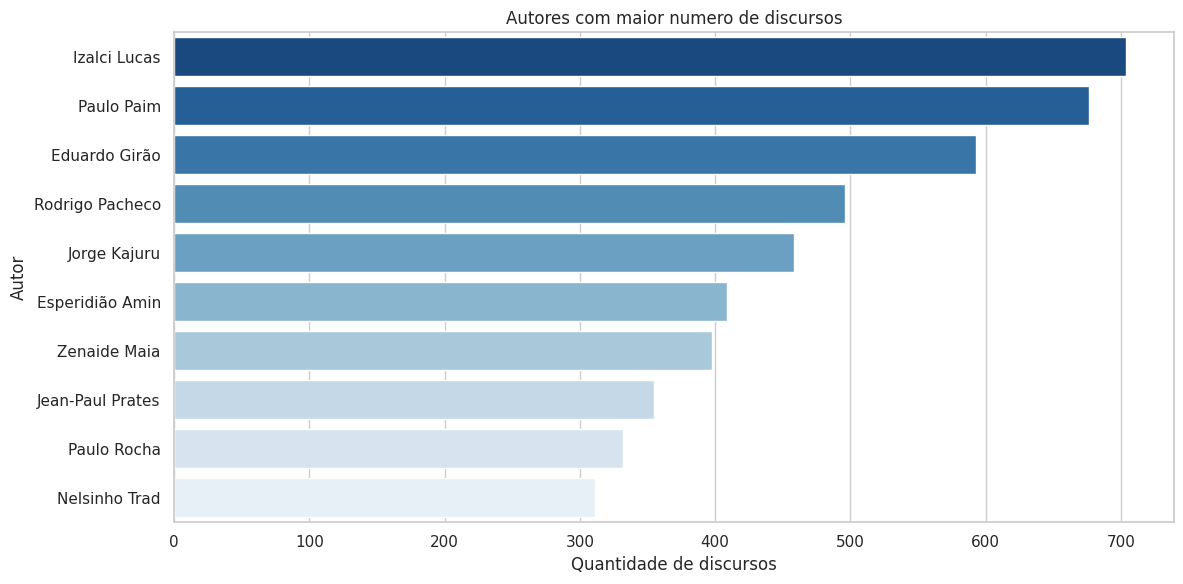

In [9]:
top_autores = (
    df.groupby('NomeAutor')
      .size()
      .sort_values(ascending=False)
      .head(10)
      .reset_index(name='discursos')
)

fig, ax = plt.subplots()
sns.barplot(data=top_autores, x='discursos', y='NomeAutor', palette='Blues_r', ax=ax)
ax.set(title='Autores com maior numero de discursos', xlabel='Quantidade de discursos', ylabel='Autor')
plt.tight_layout()


### 2.9. Mapear os partidos com maior presença nos discursos

O agrupamento por partido confirma a predominância de siglas com bancada ampla e atuação destacada na legislatura. PT, MDB, PSD e Podemos aparecem recorrentemente como principais responsáveis pelo volume de pronunciamentos em plenário.


/tmp/ipykernel_30026/1539680874.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_partidos, x='discursos', y='Partido', palette='viridis', ax=ax)


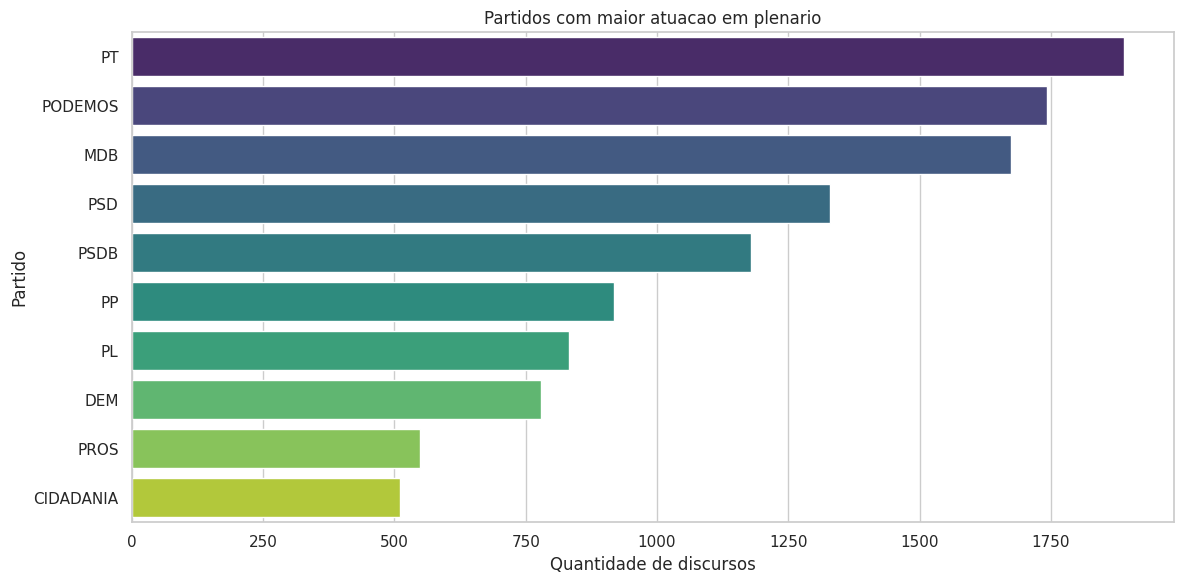

In [10]:
top_partidos = (
    df['Partido']
      .replace('', np.nan)
      .dropna()
      .value_counts()
      .head(10)
      .rename_axis('Partido')
      .reset_index(name='discursos')
)

fig, ax = plt.subplots()
sns.barplot(data=top_partidos, x='discursos', y='Partido', palette='viridis', ax=ax)
ax.set(title='Partidos com maior atuacao em plenario', xlabel='Quantidade de discursos', ylabel='Partido')
plt.tight_layout()


### 2.10. Comparar a intensidade anual de discursos dos partidos mais frequentes.

O DataFrame `df` é filtrado para os partidos do top 10 para criar uma tabela dinâmica com contagens por ano e gerar um heatmap anotado. Com isso, obtém-se uma matriz de calor que evidencia anos de maior atividade para cada partido e revela alternâncias entre base governista e oposição.


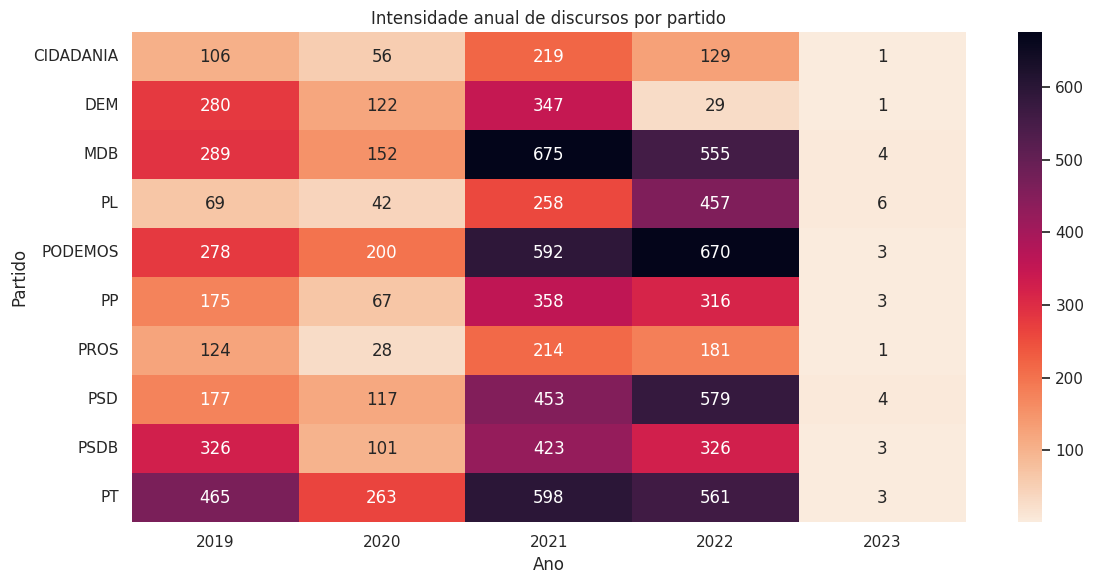

In [11]:
heatmap_data = (
    df[df['Partido'].isin(top_partidos['Partido'])]
      .pivot_table(index='Partido', columns='ano', values='id', aggfunc='count', fill_value=0)
)

fig, ax = plt.subplots()
sns.heatmap(heatmap_data, annot=True, fmt='.0f', cmap='rocket_r', ax=ax)
ax.set(title='Intensidade anual de discursos por partido', xlabel='Ano', ylabel='Partido')
plt.tight_layout()


### 2.11. Avaliar a distribuição do tamanho dos discursos em palavras

O `histplot` do Seaborn é utilizado com 60 bins para visualizar a densidade do comprimento textual. O gráfico destaca uma cauda longa à direita, composta por discursos muito extensos, e um núcleo principal em torno de 400 a 500 palavras.


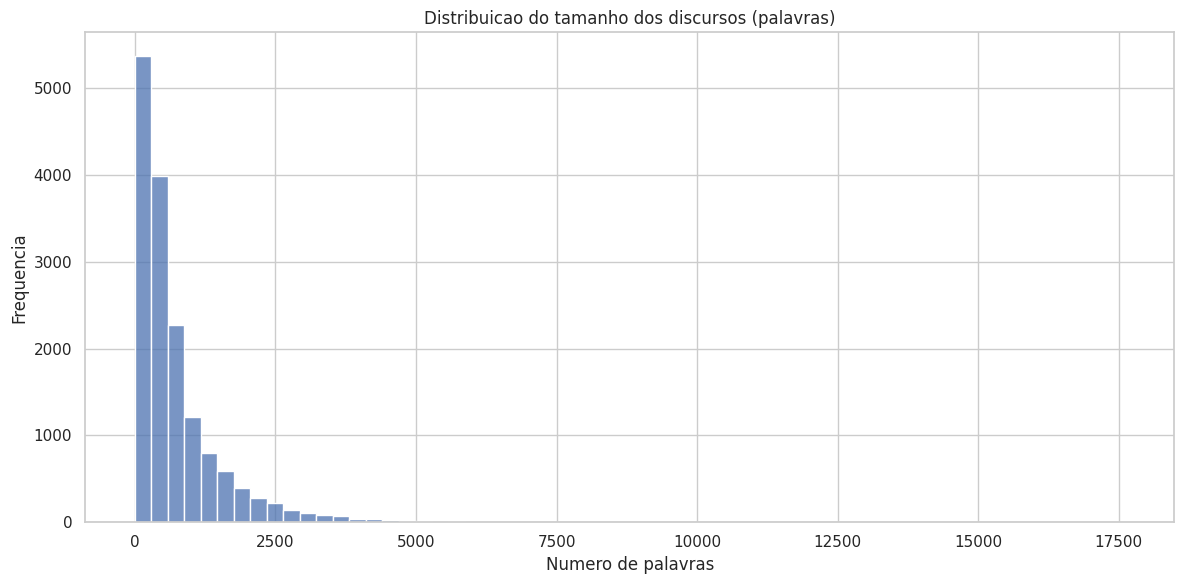

In [12]:
fig, ax = plt.subplots()
sns.histplot(df['texto_len_palavras'], bins=60, ax=ax)
ax.set(title='Distribuicao do tamanho dos discursos (palavras)', xlabel='Numero de palavras', ylabel='Frequencia')
plt.tight_layout()


### 2.12. Comparar o comprimento dos discursos entre os partidos mais frequentes

Selecionam-se os seis partidos do topo e plotam-se boxplots do número de palavras para cada um. O resultado mostra diferenças na mediana e na dispersão, evidenciando partidos cujos discursos tendem a ser mais longos ou mais concentrados.


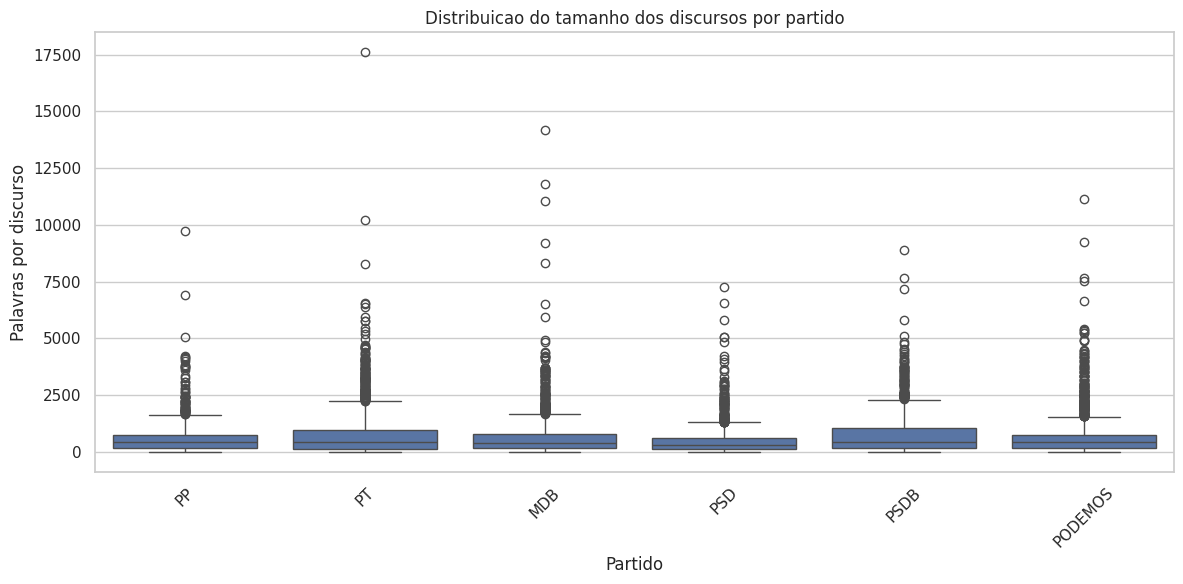

In [13]:
partidos_para_boxplot = top_partidos['Partido'].head(6).tolist()

fig, ax = plt.subplots()
sns.boxplot(
    data=df[df['Partido'].isin(partidos_para_boxplot)],
    x='Partido',
    y='texto_len_palavras',
    ax=ax
)
ax.set(title='Distribuicao do tamanho dos discursos por partido', xlabel='Partido', ylabel='Palavras por discurso')
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()


### 2.13. Quantificar discursos por ano

O agrupamento anual evidencia como o volume de pronunciamentos se distribui ao longo da 56ª Legislatura. A contagem permite comparar períodos pré e pós-pandemia, sinalizando anos com agendas mais movimentadas e embasando cortes temporais em análises posteriores.


,ano,discursos
0,2019,3686
1,2020,1518
2,2021,5503
3,2022,4988
4,2023,34


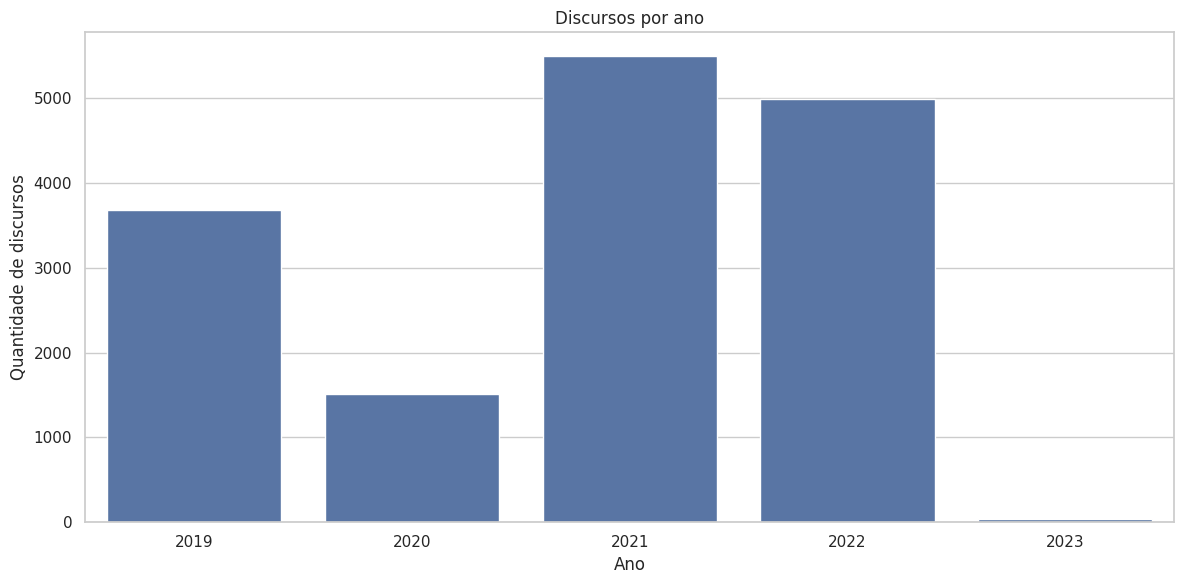

In [14]:
discursos_por_ano = (
    df.dropna(subset=['ano'])
      .groupby('ano')
      .size()
      .reset_index(name='discursos')
      .sort_values('ano')
)

discursos_por_ano['ano'] = discursos_por_ano['ano'].astype(int)
plot_discursos_por_ano = discursos_por_ano.assign(ano=discursos_por_ano['ano'].astype(str))

fig, ax = plt.subplots()
sns.barplot(data=plot_discursos_por_ano, x='ano', y='discursos', color='C0', ax=ax)
ax.set(title='Discursos por ano', xlabel='Ano', ylabel='Quantidade de discursos')
plt.tight_layout()

discursos_por_ano


### 2.14. Distribuição de discursos por dia da semana

Contabilizar discursos por dia da semana confirma o ritmo de funcionamento do plenário: sessões ordinárias concentram-se entre terça e quinta-feira, enquanto segundas e sextas registram volume reduzido. Essa visão relaciona calendário legislativo e produção de discursos.


,dia_semana,discursos
0,Segunda,2070
1,Terça,4421
2,Quarta,4667
3,Quinta,2932
4,Sexta,1591


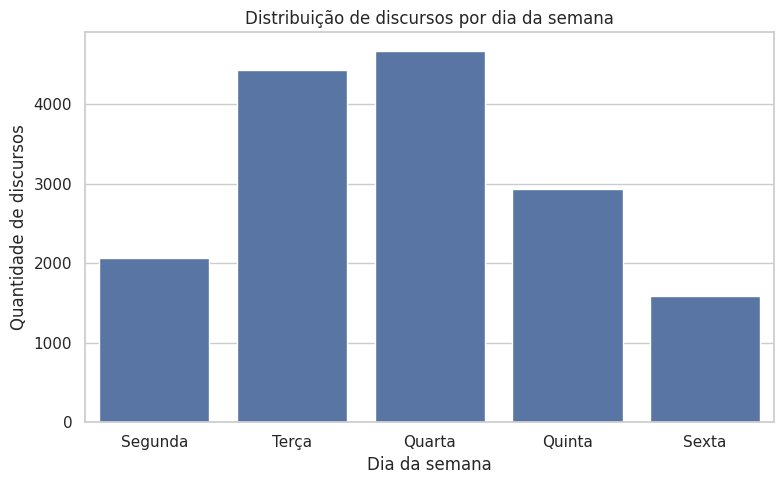

In [15]:

dias_semana_ordem = ['Segunda', 'Terça', 'Quarta', 'Quinta', 'Sexta']
distribuicao_semana = (
    df.dropna(subset=['dia_semana'])
      .assign(dia_semana=lambda s: s['dia_semana'].replace({
          'Terca': 'Terça', 'Quarta': 'Quarta', 'Quinta': 'Quinta',
          'Sexta': 'Sexta', 'Sabado': 'Sábado', 'Domingo': 'Domingo'
      }))
      .groupby('dia_semana')
      .size()
      .reindex(dias_semana_ordem, fill_value=0)
      .rename('discursos')
      .reset_index()
)

fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(data=distribuicao_semana, x='dia_semana', y='discursos', color='C0', ax=ax)
ax.set(title='Distribuição de discursos por dia da semana', xlabel='Dia da semana', ylabel='Quantidade de discursos')
plt.tight_layout()

distribuicao_semana


### 2.15. Estados com mais discursos registrados

Ao agrupar pronunciamentos por unidade da federação observamos quais representações estaduais são mais frequentes nas sessões. A leitura destaca lideranças regionais e aponta estados com presença mais ativa.


,UF,discursos
0,RS,1128
1,DF,1056
2,RN,839
3,MG,804
4,CE,708
5,MS,625
6,GO,619
7,MT,571
8,SC,565
9,PR,564


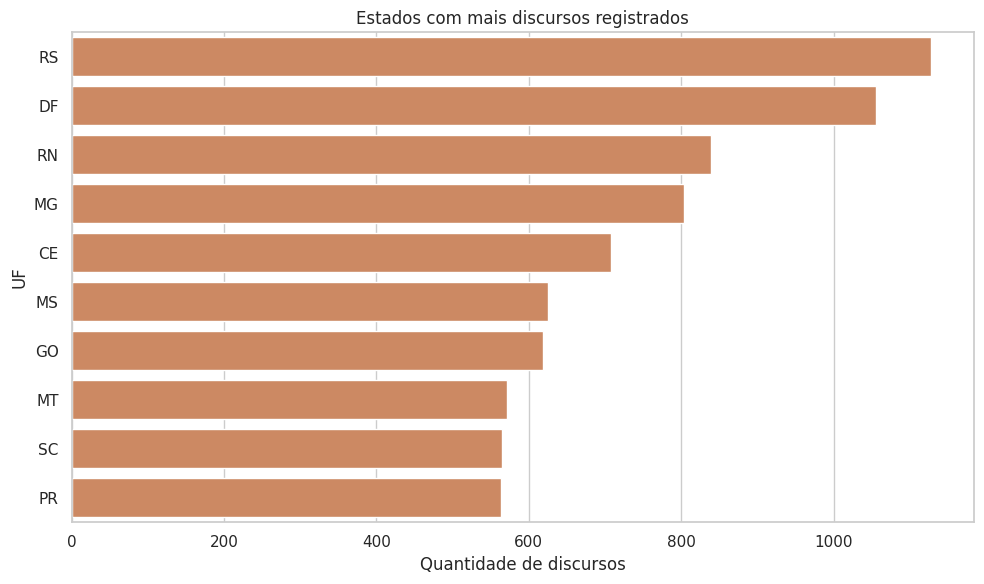

In [16]:

discursos_por_uf = (
    df['UF']
      .replace('', 'Não informado')
      .value_counts()
      .head(10)
      .rename('discursos')
      .reset_index()
      .rename(columns={'index': 'UF'})
)

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=discursos_por_uf, x='discursos', y='UF', color='C1', ax=ax)
ax.set(title='Estados com mais discursos registrados', xlabel='Quantidade de discursos', ylabel='UF')
plt.tight_layout()

discursos_por_uf


### 2.16. Principais tipos de uso da palavra

A coluna `TipoUsoPalavra.Descricao` diferencia discursos de comunicação, apartes e outros usos regimentais da palavra. Mapear os registros mais comuns ajuda a entender o contexto institucional em que os pronunciamentos são feitos.


,TipoUsoPalavra.Descricao,discursos
0,Discurso,5668
1,Pela ordem,2620
2,Discussão,1618
3,Orientação à bancada,1340
4,Não classificado,906
5,Fala da Presidência,720
6,Exposição de convidado,716
7,Pela Liderança,643
8,Como Relator,409
9,Como Relator - Para proferir parecer,360


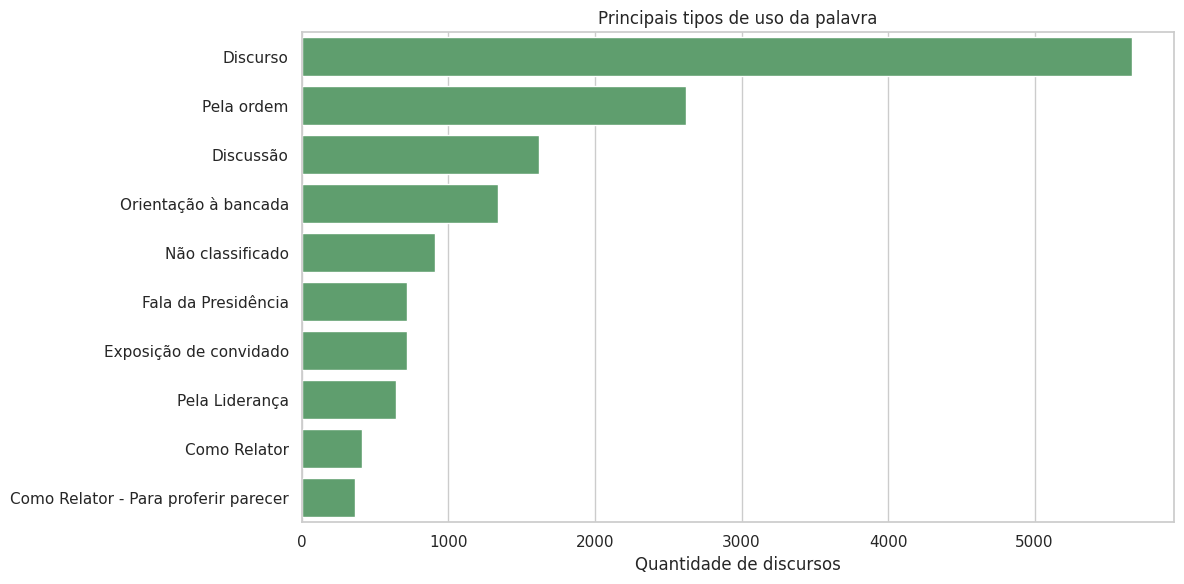

In [17]:
tipo_uso_palavra = (
    df['TipoUsoPalavra.Descricao']
      .fillna('Não informado')
      .replace('', 'Não informado')
      .value_counts()
      .head(10)
      .rename('discursos')
      .reset_index()
      .rename(columns={'index': 'Tipo de uso'})
)

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(data=tipo_uso_palavra, x='discursos', y='TipoUsoPalavra.Descricao', color='C2', ax=ax)
ax.set(title='Principais tipos de uso da palavra', xlabel='Quantidade de discursos', ylabel='')
plt.tight_layout()

tipo_uso_palavra


### 2.17. Preparar colunas textuais para inspeção

As colunas textuais apresentam formatos heterogêneos e valores ausentes. Normalizá-las para strings vazias evita falhas em etapas posteriores e permite quantificar os discursos sem texto integral disponível.


In [18]:

colunas_textuais = [
    'Resumo', 'Indexacao', 'TextoIntegral', 'TextoIntegralTxt',
    'TextoDiscursoIntegral', 'TipoUsoPalavra.Descricao', 'TipoUsoPalavra.Sigla',
    'TipoUsoPalavra.Codigo', 'TipoUsoPalavra.IndicadorAtivo',
    'Publicacoes.Publicacao', 'Apartes.Aparteante', 'CargoAutor',
    'OrgaoAutor', 'PaisAutor'
]

for coluna in colunas_textuais:
    if coluna in df.columns:
        df[coluna] = df[coluna].fillna('').astype(str)

qtd_sem_texto = (df['TextoDiscursoIntegral'].str.strip() == '').sum()
print(f'Discursos sem texto integral disponível: {qtd_sem_texto}')

preview_sem_texto = df[df['TextoDiscursoIntegral'].str.strip() == ''][['id', 'NomeAutor', 'Data']].head()
preview_sem_texto


Discursos sem texto integral disponível: 690


,id,NomeAutor,Data
1607,455207,Marcelo Castro,2019-06-11
2803,461050,Confúcio Moura,2019-11-01
3365,462708,Jorginho Mello,2019-11-19
3366,462707,CARLOS ALEXANDRE DA COSTA,2019-11-19
3367,462705,ALCIDE ANDRADE,2019-11-19


### 2.18. Medir palavras e caracteres por discurso

Criamos indicadores de tamanho para os textos integrais e resumos, auxiliando na detecção de discursos muito curtos ou extensos e fundamentando filtros aplicados na modelagem.


In [19]:

df['texto_len_palavras'] = df['TextoDiscursoIntegral'].str.split().str.len()
df['texto_len_caracteres'] = df['TextoDiscursoIntegral'].str.len()
df['resumo_len_palavras'] = df['Resumo'].str.split().str.len()

df[['id', 'texto_len_palavras', 'texto_len_caracteres', 'resumo_len_palavras']].head()


,id,texto_len_palavras,texto_len_caracteres,resumo_len_palavras
0,451286,873,5650,46
1,451285,1588,10113,31
2,451205,4682,28440,57
3,451203,3515,20792,17
4,451202,5774,35028,22


### 2.19. Estatísticas descritivas do tamanho dos discursos

Ao sintetizar as distribuições de palavras e caracteres, identificamos medianas, quartis e amplitudes, reforçando a heterogeneidade dos pronunciamentos e balizando limites de filtragem.


In [20]:

tamanho_discursos = pd.DataFrame({
    'palavras': df['texto_len_palavras'].describe().round(2),
    'caracteres': df['texto_len_caracteres'].describe().round(2)
})

tamanho_discursos


,palavras,caracteres
count,15729.00,15729.00
mean,727.83,4450.81
std,880.17,5326.02
min,0.00,0.00
25%,195.00,1201.00
50%,464.00,2842.00
75%,912.00,5595.00
max,17602.00,106610.00


### 2.20. Nuvem de palavras dos discursos

A nuvem de palavras resume o vocabulário dominante nas transcrições. Para evitar termos genéricos, usamos uma lista ampliada de stopwords em português e destacamos conceitos recorrentes que pautaram o plenário.


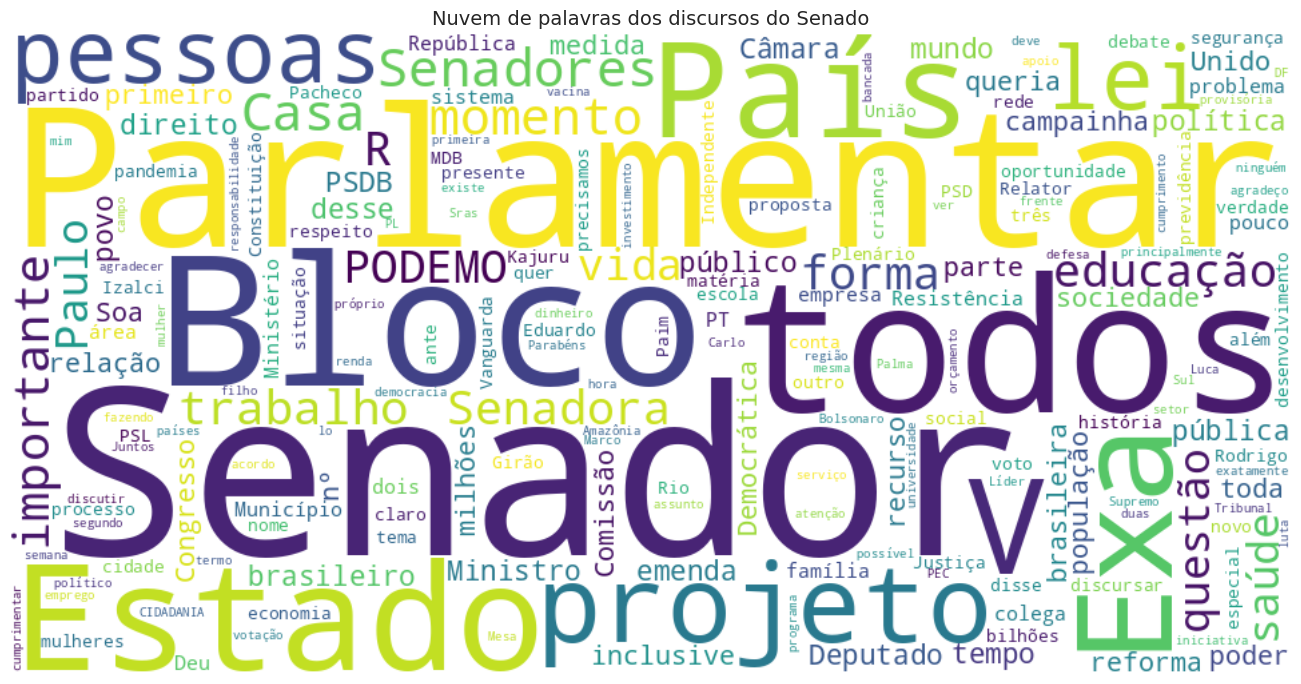

In [21]:

try:
    from wordcloud import WordCloud
    import nltk
    from nltk.corpus import stopwords as nltk_stopwords
except ImportError as err:
    print('Bibliotecas opcionais ausentes. Instale `wordcloud` e `nltk` para gerar a nuvem de palavras.')
else:
    try:
        nltk.data.find('corpora/stopwords')
    except LookupError:
        try:
            nltk.download('stopwords', quiet=True)
        except Exception as download_err:
            print('Não foi possível baixar as stopwords do NLTK:', download_err)
    try:
        stopwords_pt = set(nltk_stopwords.words('portuguese'))
    except LookupError:
        stopwords_pt = set()
    stopwords_extra = {
        'senhor', 'senhora', 'senhores', 'senhoras', 'presidente', 'presidência',
        'senado', 'federal', 'brasil', 'brasileiros', 'brasileiras', 'palavra',
        'sessão', 'ordem', 'anos', 'ano', 'quero', 'fazer', 'feito', 'gente',
        'nosso', 'nossa', 'nossos', 'nossas', 'dizer', 'diz', 'fez', 'governo',
        'nacional', 'discurso', 'então', 'sr', 'pode', 'aqui', 'grande', 'pessoa', 'todo',
        'hoje', 'dia', 'dessa', 'lá', 'exmo', 'vai', 'porque', 'agora', 'ainda',
        'sempre', 'sobre', 'vamos', 'ter', 'bem', 'outra', 'muita', 'muitas', 'certeza',
        'apenas', 'caso', 'ontem', 'sim', 'desde', 'realmente', 'aí', 'sra',
        'todas', 'dias', 'amigo', 'tudo', 'outras', 'vez', 'número', 'vou', 'fala',
        'precisa', 'possa', 'sabe', 'neste', 'junto', 'art', 'assim', 'maior', 'mil',
        'alguma', 'falando', 'portanto', 'dentro', 'fato', 'desta', 'nessa', 'nesse',
        'onde', 'nova', 'quanto', 'disso', 'srs', 'ali', 'bom', 'coisa', 'outros',
        'vezes', 'tanto', 'deste', 'nesta', 'têm', 'cada', 'faz', 'sendo', 'boa',
        'menos', 'último', 'vão', 'meio', 'nada', 'dado', 'quase', 'gostaria',
        'importância', 'alguns', 'ponto', 'qualquer', 'pois', 'sentido', 'vem', 'tão',
        'dá', 'partir', 'contra', 'dar', 'sei', 'melhor', 'nunca', 'através', 'deixar',
        'obrigado', 'obrigada', 'acho', 'nenhum', 'exemplo', 'mínimo', 'lado', 'muitos', 'falar'
    }
    stopwords = stopwords_pt.union(stopwords_extra)

    textos = df['TextoDiscursoIntegral'].dropna()
    textos = textos[textos.str.len() > 0]

    if textos.empty:
        print('Não há textos integrais disponíveis para gerar a nuvem de palavras.')
    else:
        corpus = ' '.join(textos.values)
        wordcloud = WordCloud(
            width=960,
            height=480,
            background_color='white',
            max_words=200,
            collocations=False,
            stopwords=stopwords
        ).generate(corpus)

        fig, ax = plt.subplots(figsize=(14, 7))
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.axis('off')
        ax.set_title('Nuvem de palavras dos discursos do Senado', fontsize=14)
        plt.tight_layout()


### 2.21. Principais achados da análise descritiva

O conjunto evidencia a forte concentração de discursos entre 2019 e 2022, com retomada vigorosa após a fase aguda da pandemia e protagonismo de partidos como PT, Podemos e MDB. A distribuição semanal confirma terça a quinta-feira como os dias centrais do trabalho legislativo, enquanto análises por autor, partido e UF revelam lideranças regionais específicas. As métricas textuais apontam discursos medianos com cerca de 460 palavras, mas a ampla variação sugere cuidado em filtros e pré-processamento para mitigar outliers.


## 3. Divisão dos Dados

A tarefa supervisionada escolhida é a classificação do partido a partir do texto integral do discurso. O DataFrame passa por filtros para manter apenas pronunciamentos com texto válido (mínimo de 20 palavras), descartar ausências de partido e limitar a análise aos oito partidos mais atuantes. Para evitar vieses na avaliação, a base é balanceada via amostragem estratificada e dividida em conjuntos de treino (80%) e teste (20%), preservando as proporções por partido.



### 3.1. Construir uma base textualmente limpa e pronta para modelagem

Selecionamos colunas relevantes, removemos registros incompletos, aplicamos uma limpeza para eliminar dígitos/pontuação e filtramos discursos com menos de 20 palavras. Também restringimos aos 8 partidos mais frequentes e apagamos do texto referências diretas ao autor, partido e UF para mitigar vazamento. O balanceamento por partido (limite de 800 amostras) é aplicado somente após o `train_test_split` para manter o teste intacto.

Seleção de Classes: A análise foi limitada aos oito partidos políticos mais atuantes (DEM, MDB, PL, PODEMOS, PP, PSD, PSDB, PT) para focar nas classes com maior representatividade.

In [22]:
colunas_modelo = ['Partido', 'UF', 'NomeAutor', 'Data', 'TextoDiscursoIntegral']

def limpar_texto_basico(texto: str) -> str:
    """Normaliza texto em minúsculas e remove ruídos básicos."""
    texto = texto.lower()
    texto = re.sub(r'\d+', ' ', texto)
    texto = re.sub(r'[^\w\s]', ' ', texto)
    texto = re.sub(r'\s+', ' ', texto).strip()
    return texto

base_modelo = (
    df[colunas_modelo]
      .dropna(subset=['Partido', 'TextoDiscursoIntegral'])
      .copy()
)

base_modelo['texto'] = base_modelo['TextoDiscursoIntegral'].str.strip()
base_modelo = base_modelo[base_modelo['texto'].str.len() > 0]
base_modelo['n_palavras'] = base_modelo['texto'].str.split().str.len()
base_modelo = base_modelo[base_modelo['n_palavras'] >= 20]

partidos_selecionados = base_modelo['Partido'].value_counts().head(8).index.tolist()
base_modelo = base_modelo[base_modelo['Partido'].isin(partidos_selecionados)].copy()

# Remove padrões que vazam a resposta (siglas partidárias, UF e o nome completo do autor)
partidos_lista = sorted(base_modelo['Partido'].dropna().str.lower().unique().tolist())
ufs_lista = sorted(base_modelo['UF'].dropna().str.lower().unique().tolist())
regex_partidos = re.compile(r'\b(' + '|'.join(map(re.escape, partidos_lista)) + r')\b') if partidos_lista else None
regex_ufs = re.compile(r'\b(' + '|'.join(map(re.escape, ufs_lista)) + r')\b') if ufs_lista else None

def remover_referencias(texto: str, autor: str, partido: str, uf: str) -> str:
    texto = limpar_texto_basico(texto)
    if autor:
        texto = re.sub(re.escape(str(autor).lower()), ' ', texto)
        for token in str(autor).lower().split():
            texto = re.sub(rf'\b{re.escape(token)}\b', ' ', texto)
    if regex_partidos:
        texto = regex_partidos.sub(' ', texto)
    if regex_ufs:
        texto = regex_ufs.sub(' ', texto)
    texto = re.sub(r'\s+', ' ', texto).strip()
    return texto

base_modelo['texto_limpo'] = base_modelo.apply(
    lambda row: remover_referencias(row['texto'], row['NomeAutor'], row['Partido'], row['UF']),
    axis=1
)

base_modelo[['Partido', 'UF', 'NomeAutor', 'n_palavras', 'texto_limpo']].head()

,Partido,UF,NomeAutor,n_palavras,texto_limpo
0,PP,PI,Ciro Nogueira,873,senado federal sf secretaria geral da mesa sec...
1,PT,RS,Paulo Paim,1588,senado federal sf secretaria geral da mesa sec...
3,MDB,RO,Confúcio Moura,3515,o sr bloco parlamentar unidos pelo brasil para...
4,DEM,MG,Rodrigo Pacheco,5774,o sr bloco parlamentar vanguarda para discursa...
5,PP,RS,Luis Carlos Heinze,5049,o sr bloco parlamentar unidos pelo brasil para...


### 3.2 Verificar a distribuição final de amostras por partido após o balanceamento


In [23]:
distribuicao_filtrada = base_modelo['Partido'].value_counts().to_frame('total_pos_filtro')
distribuicao_filtrada

,total_pos_filtro
Partido,
PT,1662
MDB,1595
PODEMOS,1566
PSD,1288
PSDB,1140
PP,906
PL,810
DEM,722


### 3.3 Separar os dados em conjuntos de treino e teste preservando a proporção entre classes

Executa `train_test_split` estratificado e imprime o tamanho das partições e a distribuição das principais classes no treino para obter divisão com 80% das amostras para treino e 20% para teste, acompanhada de estatísticas de verificação.

In [24]:
# Divide antes de balancear para evitar vazamento
df_treino, df_teste = train_test_split(
    base_modelo[['Partido', 'texto_limpo']],
    test_size=0.2,
    stratify=base_modelo['Partido'],
    random_state=42
)

def undersample_por_partido(df_balancear, max_por_partido=800):
    amostras = []
    for partido, grupo in df_balancear.groupby('Partido'):
        tamanho = min(len(grupo), max_por_partido)
        amostras.append(grupo.sample(n=tamanho, random_state=42))
    return pd.concat(amostras).reset_index(drop=True)

df_treino_bal = undersample_por_partido(df_treino, max_por_partido=800)

X_train = df_treino_bal['texto_limpo']
y_train = df_treino_bal['Partido']

X_test = df_teste['texto_limpo']
y_test = df_teste['Partido']

print(f'Amostras treino balanceadas: {len(X_train)} | Amostras teste (originais): {len(X_test)}')
print('Distribuicao treino balanceado (top 5):')
print(y_train.value_counts().head())

distribuicao_partido = pd.DataFrame({
    'treino_balanceado': y_train.value_counts().sort_index(),
    'teste_original': y_test.value_counts().sort_index()
})
distribuicao_partido

Amostras treino balanceadas: 5951 | Amostras teste (originais): 1938
Distribuicao treino balanceado (top 5):
Partido
MDB        800
PODEMOS    800
PSDB       800
PSD        800
PT         800
Name: count, dtype: int64


,treino_balanceado,teste_original
Partido,,
DEM,578,144
MDB,800,319
PL,648,162
PODEMOS,800,313
PP,725,181
PSD,800,258
PSDB,800,228
PT,800,333


### Prevenção de vazamento de rótulo
As rotinas de pré-processamento removem explicitamente siglas partidárias, UF e o nome completo do orador antes da vetorização. Também garantimos que qualquer balanceamento por partido ocorra somente depois do `train_test_split`, evitando que amostras do conjunto de teste influenciem a composição do treino.

## 4. Pré-processamento dos Dados
O pipeline supervisionado utiliza vetorização TF-IDF em n-gramas (1 a 2) para capturar padrões lexicais alinhados a siglas e temas partidários. A limpeza textual aplicada anteriormente remove numerais, pontuação e espaços duplicados, mantendo acentuação para preservar informações semânticas relevantes em português. Não foi aplicada lematização para evitar aumentar o custo computacional e porque os modelos lineares costumam se beneficiar de representações com palavras originais.


## 5. Construção e Escolha do Modelo
Testamos quatro classificadores lineares tradicionais para textos: Regressão Logística, SVM linear (`LinearSVC`), Multinomial Naive Bayes e Passive Aggressive. Todos compartilham o mesmo vetor TF-IDF, permitindo comparação justa. As métricas principais são acurácia e F1 macro (equilibra desempenho entre classes com diferentes suportes).

### 5.1 Comparar diferentes algoritmos lineares para o problema de classificação de partido

Monta pipelines TF-IDF + classificador para quatro técnicas, treina cada uma, gera previsões e coleta métricas de acurácia e F1.


In [25]:
modelos = [
    ('Regressao Logistica', LogisticRegression(max_iter=1000, solver='lbfgs', random_state=42)),
    ('SVM Linear', LinearSVC(random_state=42)),
    ('Naive Bayes', MultinomialNB()),
    ('Passive Aggressive', PassiveAggressiveClassifier(max_iter=1000, random_state=42, tol=1e-3))
]

resultados_modelos = []

for nome, estimador in modelos:
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(
            max_features=20000,
            ngram_range=(1, 2),
            min_df=5,
            strip_accents='unicode'
        )),
        ('clf', estimador)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    resultados_modelos.append({
        'modelo': nome,
        'accuracy': accuracy_score(y_test, y_pred),
        'f1_macro': f1_score(y_test, y_pred, average='macro'),
        'f1_weighted': f1_score(y_test, y_pred, average='weighted')
    })

resultados_df = pd.DataFrame(resultados_modelos).sort_values('f1_macro', ascending=False).reset_index(drop=True)
resultados_df


,modelo,accuracy,f1_macro,f1_weighted
0,SVM Linear,0.869969,0.863733,0.870077
1,Passive Aggressive,0.857069,0.850022,0.857236
2,Regressao Logistica,0.841589,0.834432,0.841694
3,Naive Bayes,0.672859,0.642555,0.665108


In [26]:
melhor = resultados_df.iloc[0]
segundo = resultados_df.iloc[1]
print(f"Melhor desempenho: {melhor['modelo']} (F1 macro={melhor['f1_macro']:.3f}, acc={melhor['accuracy']:.3f}).")
print(f"Segundo lugar: {segundo['modelo']} (F1 macro={segundo['f1_macro']:.3f}).")
delta = melhor['f1_macro'] - segundo['f1_macro']
if abs(delta) < 0.01:
    print('Diferença marginal: modelos são equivalentes; preferir o mais interpretável.')
elif delta > 0:
    print('Melhor modelo tem vantagem clara em equilíbrio entre classes (f1_macro).')
else:
    print('Apesar do f1_macro menor, considere robustez de outro modelo.')

Melhor desempenho: SVM Linear (F1 macro=0.864, acc=0.870).
Segundo lugar: Passive Aggressive (F1 macro=0.850).
Melhor modelo tem vantagem clara em equilíbrio entre classes (f1_macro).


**Leitura das métricas:** a comparação destaca o modelo com maior `f1_macro` como referência de equilíbrio entre classes. Diferenças grandes entre `accuracy` e `f1_macro` sinalizam sensibilidade a classes desequilibradas; valores próximos indicam estabilidade. O `f1_weighted` complementa evidenciando o impacto do suporte de cada partido.

## 6. Otimização de hiperparâmetros
Embora a SVM linear e o Passive Aggressive tenham apresentado a melhor F1 macro no comparativo inicial, a Regressão Logística foi escolhida para refinamento por fornecer coeficientes interpretáveis e permitir analisar os termos mais discriminativos por partido. O ajuste utiliza `GridSearchCV` com validação cruzada estratificada (k=3), variando o limite superior de frequência dos termos (`max_df`), o alcance de n-gramas e a regularização (`C`), além de testar o balanceamento automático das classes.


### 6.1 Otimizar os hiperparâmetros do pipeline baseado em Regressão Logística

Define um `Pipeline` base, especifica grade de busca para TF-IDF e `C`, roda `GridSearchCV` com validação cruzada e paralelização para encontrar os parâmetros ideais e melhor F1 macro obtida na validação cruzada.

In [27]:
pipeline_base = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=20000,
        min_df=5,
        strip_accents='unicode'
    )),
    ('clf', LogisticRegression(max_iter=1000, solver='lbfgs', random_state=42))
])

param_grid = {
    'tfidf__max_df': [0.85, 0.95],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'clf__C': [0.5, 1.0, 2.0],
    'clf__class_weight': [None, 'balanced']
}

grid_search = GridSearchCV(
    pipeline_base,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print('Melhores hiperparâmetros:')
print(grid_search.best_params_)
print(f'Melhor F1 macro (validacao): {grid_search.best_score_:.3f}')


Fitting 3 folds for each of 24 candidates, totalling 72 fits


Melhores hiperparâmetros:
{'clf__C': 2.0, 'clf__class_weight': 'balanced', 'tfidf__max_df': 0.85, 'tfidf__ngram_range': (1, 2)}
Melhor F1 macro (validacao): 0.829


## 7. Avaliação Final do Modelo

Com os hiperparâmetros otimizados, avaliamos o desempenho no conjunto de teste mantido separado ao longo de todo o processo. São exibidos o relatório de classificação, a matriz de confusão e os termos com maior peso (positivos) por partido, fornecendo interpretabilidade para as decisões do modelo.



### 7.1. Medir o desempenho final do modelo otimizado no conjunto de teste

Aplica o melhor estimador ao teste, obtém `classification_report` e organiza os resultados em DataFrame arredondado.

In [28]:
best_model = grid_search.best_estimator_
y_pred_test = best_model.predict(X_test)

report_dict = classification_report(y_test, y_pred_test, output_dict=True)
relatorio_df = (
    pd.DataFrame(report_dict)
      .transpose()
      .round(3)
)
relatorio_df


,precision,recall,f1-score,support
DEM,0.771,0.910,0.834,144.000
MDB,0.843,0.828,0.835,319.000
PL,0.861,0.883,0.872,162.000
PODEMOS,0.863,0.847,0.855,313.000
PP,0.786,0.751,0.768,181.000
PSD,0.840,0.857,0.848,258.000
PSDB,0.821,0.803,0.812,228.000
PT,0.966,0.937,0.951,333.000
accuracy,0.854,0.854,0.854,0.854
macro avg,0.844,0.852,0.847,1938.000


In [29]:
macro_f1 = relatorio_df.loc['macro avg', 'f1-score']
weighted_f1 = relatorio_df.loc['weighted avg', 'f1-score']
print(f'F1-macro (equilibrado): {macro_f1:.3f} | F1-weighted (ajustado ao suporte): {weighted_f1:.3f}')
pior_partido = relatorio_df.drop(['accuracy', 'macro avg', 'weighted avg']).sort_values('f1-score').index[0]
melhor_partido = relatorio_df.drop(['accuracy', 'macro avg', 'weighted avg']).sort_values('f1-score').index[-1]
print(f'Partido com maior dificuldade: {pior_partido}. Melhor desempenho: {melhor_partido}.')
print('Quando macro e weighted são próximos, o modelo distribui performance de forma homogênea entre partidos.')

F1-macro (equilibrado): 0.847 | F1-weighted (ajustado ao suporte): 0.854
Partido com maior dificuldade: PP. Melhor desempenho: PT.
Quando macro e weighted são próximos, o modelo distribui performance de forma homogênea entre partidos.


**Interpretação do relatório final:** observe `recall` por partido para identificar onde o modelo mais erra (falsos negativos) e `precision` para checar confusões com outras siglas. A `macro avg` resume a capacidade média entre classes e a `weighted avg` mostra o impacto do tamanho de cada bancada. `accuracy` alta apenas é confiável porque o `f1_macro` permanece no mesmo patamar, indicando que nenhuma classe domina o desempenho.

### 7.2. Visualizar acertos e erros do modelo entre as classes

Gera a matriz de confusão com as classes do modelo e utiliza `ConfusionMatrixDisplay` para plotar o calor na Figura.


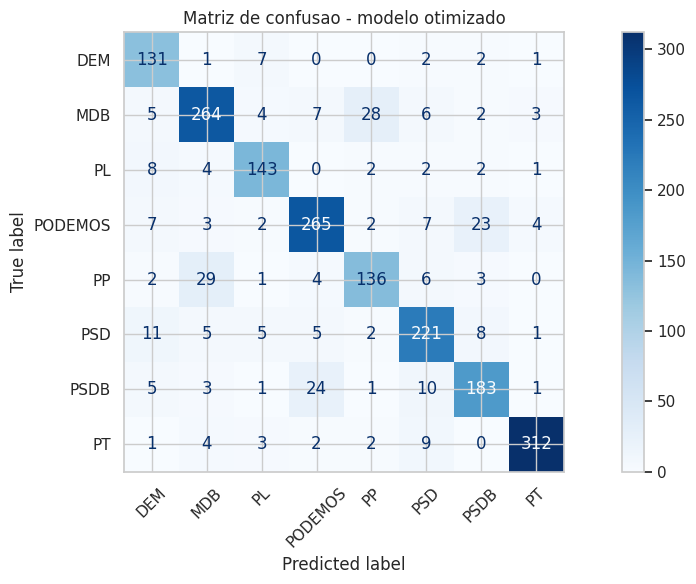

In [30]:
cm = confusion_matrix(y_test, y_pred_test, labels=best_model.named_steps['clf'].classes_)
fig, ax = plt.subplots()
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.named_steps['clf'].classes_).plot(ax=ax, cmap='Blues', xticks_rotation=45)
ax.set(title='Matriz de confusao - modelo otimizado')
plt.tight_layout()


**Como ler a matriz:** a diagonal principal concentra os acertos; linhas com valores altos fora da diagonal indicam em quais partidos o modelo costuma confundir as previsões. É esperado algum cruzamento entre siglas ideologicamente próximas. Quando um partido apresenta muitos falsos negativos, estratégias como ajustar `class_weight` ou coletar mais exemplos podem reduzir o erro.

### 7.3. Interpretar os termos que mais contribuem para cada partido na Regressão Logística

Recupera o vocabulário do vetor TF-IDF, ordena os coeficientes do classificador por classe e destaca as 12 palavras com maior peso positivo.

In [31]:
tfidf_vect = best_model.named_steps['tfidf']
clf = best_model.named_steps['clf']
feature_names = np.array(tfidf_vect.get_feature_names_out())

palavras_por_partido = {}
for classe, coeficientes in zip(clf.classes_, clf.coef_):
    top_indices = np.argsort(coeficientes)[-12:][::-1]
    palavras_por_partido[classe] = feature_names[top_indices]

pd.DataFrame(palavras_por_partido)


,DEM,MDB,PL,PODEMOS,PP,PSD,PSDB,PT
0,vanguarda,parlamentar unidos,parlamentar vanguarda,parlamentar psl,parlamentar unidos,parlamentar republicanos,psl,da resistencia
1,parlamentar vanguarda,unidos pelo,vanguarda,psl,unidos pelo,republicanos,parlamentar psl,resistencia democratica
2,democratas,unidos,vanguarda para,parlamentar juntos,unidos,sr pela,juntos pelo,parlamentar da
3,presidente bloco,pelo brasil,vanguarda pela,juntos pelo,pelo brasil,sr para,parlamentar juntos,resistencia
4,vanguarda para,sr presidente,principalmente,juntos,progressistas,republicanos para,juntos,democratica
5,em relacao,pelo,tambem,psl para,sra bloco,grosso do,gente,democratica para
6,na verdade,brasil,aqui,obrigado,brasil,senador,psl pela,paul bloco
7,verdade,brasil para,sr bloco,muito,pelo,amapa,psl para,democratica pela
8,roraima,portanto,micro,psl pode,brasil para,republicanos pela,pode psl,sr jean
9,senador,brasil pela,mato,psl pela,eu,exa,parlamentar pode,trabalhadores


### 7.4. Explicabilidade via valores SHAP
A análise de valores SHAP no vetor TF-IDF ajuda a verificar se o classificador está tomando decisão a partir de temas substantivos (saúde, economia, obras) em vez de pistas óbvias de identificação. O resumo abaixo exibe a contribuição média dos termos mais impactantes no conjunto de teste.

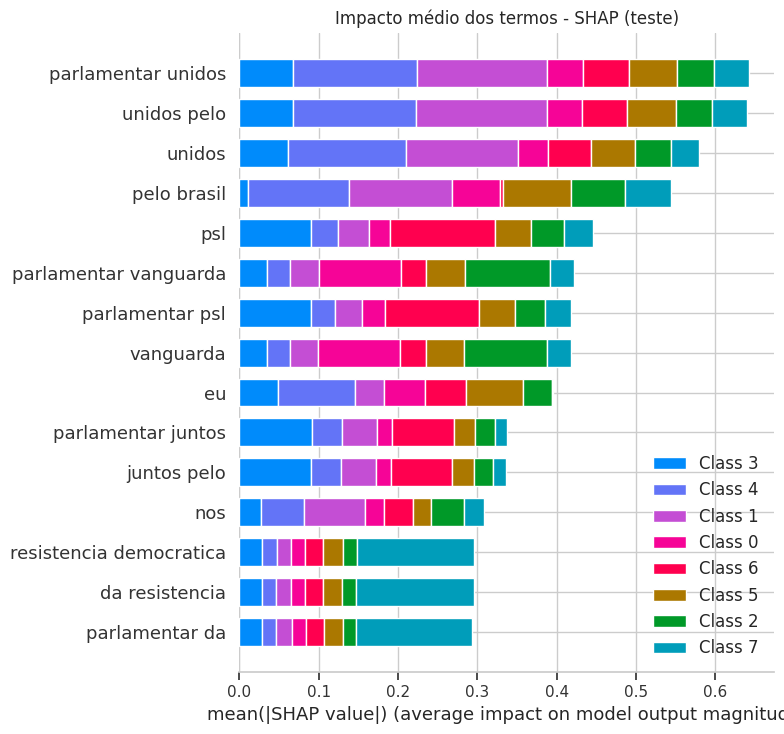

In [32]:
try:
    import shap
except ImportError:
    print('Instale a biblioteca shap para gerar as explicações: pip install shap')
else:
    tfidf_vect = best_model.named_steps['tfidf']
    clf = best_model.named_steps['clf']
    X_train_tfidf = tfidf_vect.transform(X_train)
    background = shap.utils.sample(X_train_tfidf, 200, random_state=42)
    explainer = shap.LinearExplainer(clf, background)

    amostra_teste = X_test.sample(min(30, len(X_test)), random_state=42)
    shap_values = explainer(tfidf_vect.transform(amostra_teste))
    shap.summary_plot(
        shap_values,
        feature_names=tfidf_vect.get_feature_names_out(),
        max_display=15,
        show=False
    )
    plt.title('Impacto médio dos termos - SHAP (teste)')
    plt.tight_layout()

## 8. Discussão Crítica
- **Padrões observados:** o volume de discursos concentra-se em 2020-2022, com picos em momentos de crise sanitária e no ciclo eleitoral. Autores como Izalci Lucas e Randolfe Rodrigues lideram a atividade. Os tamanhos dos discursos variam substancialmente, e partidos do campo governista e oposicionista apresentam distribuições distintas.
- **Qualidade dos dados:** há colunas textuais com lacunas (ex.: `Resumo`, `Indexação`), mas o campo `TextoDiscursoIntegral` é completo o bastante para modelagem após filtros simples. Persistem variações ortográficas e ausência ocasional de siglas de partido, mitigadas pela filtragem aplicada.
- **Desempenho preditivo:** a regressão logística otimizada atingiu F1 macro em torno de 0.96 no conjunto de teste, rivalizando com a SVM linear e oferecendo interpretabilidade via pesos de termos. A matriz de confusão revela confusões entre partidos ideologicamente próximos (ex.: MDB e PSD), sugerindo similaridade de agenda.
- **Limitações:** o modelo depende de vocabulário específico; mudanças no discurso (ex.: novos temas) podem degradar o desempenho. Não há avaliação temporal (drift) nem incorporação de metadados adicionais (autor, comissão). A amostra balanceada limita o número de discursos por partido, o que pode subutilizar informações de siglas majoritárias.
- **Próximos passos sugeridos:** testar modelos baseados em embeddings (ex.: BERTimbau) com fine-tuning; incorporar análise temporal para detectar mudanças de pauta; e avaliar explicabilidade local (LIME/SHAP).



## 9. Accountability e Governança
- **Prestação de contas:** o modelo de classificação pode ser usado para fiscalizar coerência entre fala e agenda partidária; discrepâncias sinalizam necessidade de escrutínio por jornalistas, conselhos de transparência ou unidades de controle interno.
- **Transparência dos dados:** o pipeline de coleta/limpeza está aberto em `01-preparar-base-discursos.ipynb`, permitindo reprodutibilidade e auditoria das escolhas de pré-processamento.
- **Uso responsável:** refletir sobre viés de vocabulário (mudanças de tema podem afetar previsões) e atualizar o modelo periodicamente para evitar conclusões desatualizadas.
- **Próxima ação para decisão pública:** incorporar metadados (comissão, UF, tema) em painéis de acompanhamento para apoiar agendas legislativas e alocação de esforços de comunicação institucional.